# Предсказание температуры стали

# Описание задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы
1) Описание проекта, задачи

2) Изучение и подготовка данных:
 - Выгрузка данных
 - Инициализация данных
 - Анализ данных
 - Описание данных
 
3) Предобработка данных:
 - Проверка типов данных
 - Работа с проспусками
 
4) Подготовка данных:
 - Проверка на мультиколлинеарность
 - Формирование итоговых датафреймов
 - Формирование целевого и остальных признаков
 - Формирвоание обучающих, валид и тест выборок
 
5) Обучение моделей:
 - 3-4 модели
 
6) Тестирование моделей:
 - Анализ важности факторов
 
7) Итоговый вывод

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# 1. Изучение и подготовка данных

In [2]:
pth1 = '/datasets/final_steel/data_arc.csv'
pth2 = 'data_arc.csv'

if os.path.exists(pth1):
    data_arc = pd.read_csv(pth1, parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
elif os.path.exists(pth2):
    data_arc = pd.read_csv(pth2, parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
else:
    print('Something is wrong') 

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [4]:
data_arc.head(3)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


In [5]:
# Видим что значения key повторяются, это означает кол-во итериаций обработки материала
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

<AxesSubplot:>

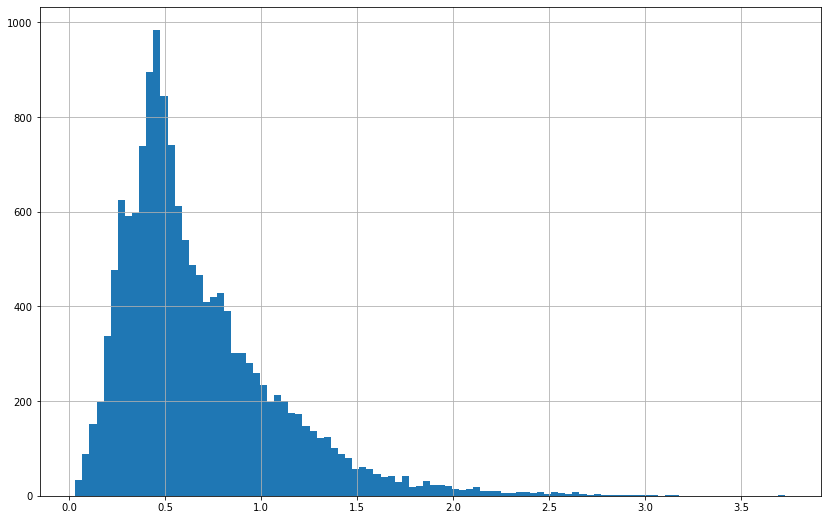

In [6]:
# Процесс нагрева происходит при Активной мощности, посомтрим ее значения и график
display(data_arc['Активная мощность'].describe())
data_arc['Активная мощность'].hist(bins=100, figsize=(14,9))

В целом видим нормальное распределение  активной мощности

In [7]:
pth1 = '/datasets/final_steel/data_bulk.csv'
pth2 = 'data_bulk.csv'

if os.path.exists(pth1):
    data_bulk = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_bulk = pd.read_csv(pth2)
else:
    print('Something is wrong') 

In [8]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [10]:
data_bulk['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

Видим что в данной таблице key уникален в каждой строке

In [11]:
#Так как наглядно не видно, есть ли значения в других 'Bulk', выведем по ним данные 
for column in data_bulk.columns:
    if column[0] == 'B':
        print(column)
        display(data_bulk[column].describe())

Bulk 1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

Bulk 2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

Bulk 3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Bulk 4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

Bulk 5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

Bulk 6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Bulk 7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

Bulk 8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

Bulk 9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

Bulk 10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

Bulk 11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

Bulk 12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Bulk 13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

Bulk 14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Bulk 15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

In [12]:
pth1 = '/datasets/final_steel/data_bulk_time.csv'
pth2 = 'data_bulk_time.csv'

if os.path.exists(pth1):
    data_bulk_time = pd.read_csv(pth1, parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                                      'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11',
                                                      'Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
elif os.path.exists(pth2):
    data_bulk_time = pd.read_csv(pth2, parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                                      'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11',
                                                      'Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
else:
    print('Something is wrong') 

In [13]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [14]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaT,NaT,NaT,2019-05-03 13:59:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:53:27,NaT,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaT,NaT,NaT,2019-05-03 14:29:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:22:19,NaT,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaT,NaT,NaT,2019-05-03 15:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:55:46,NaT,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaT,NaT,NaT,2019-05-03 15:47:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:41:00,NaT,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 16:18:52,NaT,2019-05-03 16:18:52,2019-05-03 16:18:52


In [15]:
data_bulk_time['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

Также key не повторяется

In [16]:
pth1 = '/datasets/final_steel/data_gas.csv'
pth2 = 'data_gas.csv'

if os.path.exists(pth1):
    data_gas = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_gas = pd.read_csv(pth2)
else:
    print('Something is wrong') 

In [17]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [18]:
data_gas.head(3)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [19]:
data_gas['key'].value_counts()

2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049    1
Name: key, Length: 3239, dtype: int64

Также key не повторяется

In [20]:
pth1 = '/datasets/final_steel/data_temp.csv'
pth2 = 'data_temp.csv'

if os.path.exists(pth1):
    data_temp = pd.read_csv(pth1, parse_dates = ['Время замера'])
elif os.path.exists(pth2):
    data_temp = pd.read_csv(pth2, parse_dates = ['Время замера'])
else:
    print('Something is wrong') 

In [21]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [22]:
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [23]:
data_temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

Видим что по некоторым партиям было несоклько замеров, также видим что в  некоторых строках не заполнена температура

<AxesSubplot:>

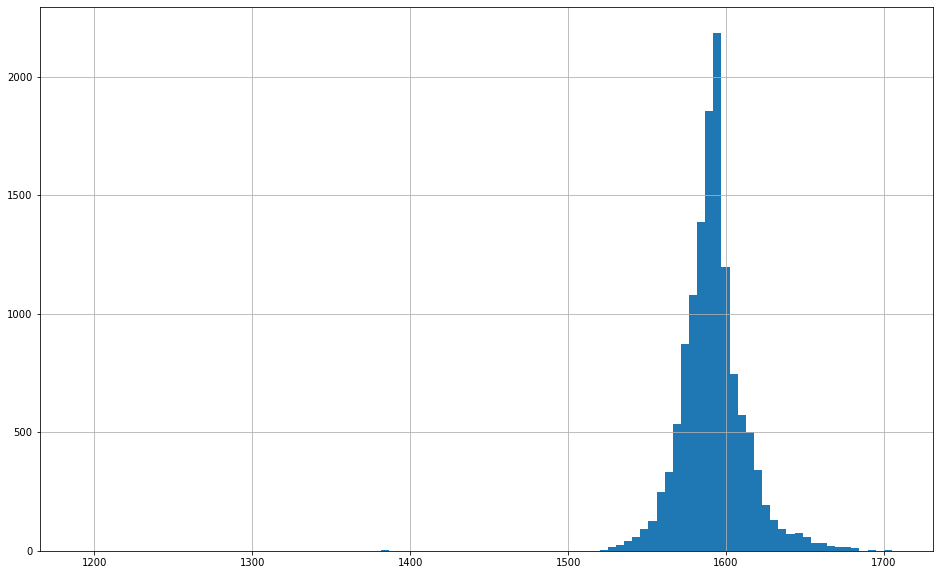

In [24]:
# Посмотрим на график температур
data_temp['Температура'].hist(bins=100, figsize=(16,10))

График имеет нормальное распределение, также видим некороые выбросы в диапазонах до 1400 и после 1680. Температура плавления стали ~ 1550 градусов

In [25]:
pth1 = '/datasets/final_steel/data_wire.csv'
pth2 = 'data_wire.csv'

if os.path.exists(pth1):
    data_wire = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_wire = pd.read_csv(pth2)
else:
    print('Something is wrong') 

In [26]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [27]:
data_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# По аналогии с 'Bulk' выведем данные по 'Wire'
for column in data_wire.columns:
    if column[0] == 'W':
        print(column)
        display(data_wire[column].describe())

Wire 1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060484
max       330.314424
Name: Wire 1, dtype: float64

Wire 2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Wire 3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

Wire 4


count     14.000000
mean      57.442842
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

Wire 5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

Wire 6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

Wire 7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

Wire 8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

Wire 9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

In [29]:
pth1 = '/datasets/final_steel/data_wire_time.csv'
pth2 = 'data_wire_time.csv'

if os.path.exists(pth1):
    data_wire_time = pd.read_csv(pth1, parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
elif os.path.exists(pth2):
    data_wire_time = pd.read_csv(pth2, parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
else:
    print('Something is wrong') 

In [30]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [31]:
data_wire_time.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [32]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [33]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [34]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [35]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [36]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


## 1.1. Вывод
После 1 этапа работ можно сделать следующие выводы:
1) Столбцы на разных языках. Имена столбцов нужно превести к общепринятому виду (английским языком, прописными буквами и без пробелов).

2) Во всех столбцах фреймов _date необходим перевод времени в формат datetime. Что мы и сделали сразу при выгрузке данных)

3) Есть столбцы, которые могут не использовать тип float, так как хранят только целые числа.

4) Целевым признаком будет последний замер температуры в `data_temp`

5) Пропуски в столбцах могут быть по разным причинам: ошибка переноса, ошибка датчика или же просто остутсвие необходимости в проведении действия (нагрев, добавка присадок и пр.)

Данные требуют групировки по нормеру партии key, также небходимо поправить все вышеперечисленные замечания.

# 2. Предобработка данных

In [37]:
# Приведем столбцы датасета в правильный вид для удобной работы с данными и экономии времени
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_bulk.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
data_bulk_time.columns = ['key', 'bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8',
                     'bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14','bulk_15']
data_gas.columns = ['key', 'gas_1']
data_temp.columns = ['key', 'time','temp']
data_wire.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']
data_wire_time.columns = ['key','wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9']

In [38]:
data_arc = data_arc.query('reactive_power > 0')

In [39]:
# Как мы уже поняли целевым признаком будет последний замер температуры, 
#но также мы увидели что в этот датасете значения кей повторяется.
# Создадим переменную, которая будет отвечать за кол-во итераций по партии
iterations = data_temp['key'].value_counts()
iterations = iterations.sort_index()
print(iterations)
iterations.loc[2]

1       5
2       6
3       5
4       3
5       2
       ..
3237    5
3238    3
3239    8
3240    8
3241    5
Name: key, Length: 3216, dtype: int64


6

Обращаем внимание, что мы не можем просто взять 'key' как индекс, так как некоторых 'key' нет в 'data_temp'

In [40]:
# Сделаем так, чтобы бралась последняя итерация партии, проверялось есть ли у этой итерации замермтемпературы,
#если нет, то берем все улючи, кроме этого
s = -1 
k = 0
key_of_data_temp = set()
for key in data_temp.key.unique():
    s = s + iterations.loc[key]
    if (data_temp.loc[s]['time'] == data_temp[data_temp["key"] == key]['time'].max()): #последний замер температуры находится на последнем месте 
        k = k + 1
        key_of_data_temp.add(key)
    if np.isnan(data_temp.loc[s].temp) == True: #удаление партий без последнего замера температуры
        data_temp = data_temp.loc[data_temp['key'] != key]
        data_arc = data_arc.loc[data_arc['key'] != key]
        data_gas = data_gas.loc[data_gas['key'] != key]
        data_bulk = data_bulk.loc[data_bulk['key'] != key]
        data_wire = data_wire.loc[data_wire['key'] != key]
        data_wire_time = data_wire_time.loc[data_wire_time['key'] != key]
        data_bulk_time = data_bulk_time.loc[data_bulk_time['key'] != key]
print(k)

3216


In [41]:
# Построим функцию по поиску пропусков
def show_isna(df):
    for column in df.columns:
        print('Количество пропусков в каждом столбце')    
        print(df.isna().mean())

In [42]:
show_isna(data_wire_time)
data_wire_time = data_wire_time.fillna(0)

Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждо

In [43]:
show_isna(data_bulk)
data_bulk = data_bulk.fillna(0)

Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917359
bulk_2     0.994601
bulk_3     0.599252
bulk_4     0.661960
bulk_5     0.977990
bulk_6     0.815615
bulk_7     0.994186
bulk_8     0.999585
bulk_9     0.994601
bulk_10    0.940615
bulk_11    0.946013
bulk_12    0.218439
bulk_13    0.994186
bulk_14    0.112542
bulk_15    0.288621
dtype: float64
Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917359
bulk_2     0.994601
bulk_3     0.599252
bulk_4     0.661960
bulk_5     0.977990
bulk_6     0.815615
bulk_7     0.994186
bulk_8     0.999585
bulk_9     0.994601
bulk_10    0.940615
bulk_11    0.946013
bulk_12    0.218439
bulk_13    0.994186
bulk_14    0.112542
bulk_15    0.288621
dtype: float64
Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917359
bulk_2     0.994601
bulk_3     0.599252
bulk_4     0.661960
bulk_5     0.977990
bulk_6     0.815615
bulk_7     0.994186
bulk_8     0.999585
bulk_9     0.994601
bulk_10    0.940

In [44]:
show_isna(data_wire)
data_wire = data_wire.fillna(0)

Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждом столбце
key       0.000000
wire_1    0.010114
wire_2    0.648968
wire_3    0.983565
wire_4    0.994943
wire_5    1.000000
wire_6    0.981037
wire_7    0.998314
wire_8    0.994522
wire_9    0.988201
dtype: float64
Количество пропусков в каждо

In [45]:
show_isna(data_bulk_time)
data_bulk_time = data_bulk_time.fillna(0)

Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917359
bulk_2     0.994601
bulk_3     0.599252
bulk_4     0.661960
bulk_5     0.977990
bulk_6     0.815615
bulk_7     0.994186
bulk_8     0.999585
bulk_9     0.994601
bulk_10    0.940615
bulk_11    0.946013
bulk_12    0.218439
bulk_13    0.994186
bulk_14    0.112542
bulk_15    0.288621
dtype: float64
Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917359
bulk_2     0.994601
bulk_3     0.599252
bulk_4     0.661960
bulk_5     0.977990
bulk_6     0.815615
bulk_7     0.994186
bulk_8     0.999585
bulk_9     0.994601
bulk_10    0.940615
bulk_11    0.946013
bulk_12    0.218439
bulk_13    0.994186
bulk_14    0.112542
bulk_15    0.288621
dtype: float64
Количество пропусков в каждом столбце
key        0.000000
bulk_1     0.917359
bulk_2     0.994601
bulk_3     0.599252
bulk_4     0.661960
bulk_5     0.977990
bulk_6     0.815615
bulk_7     0.994186
bulk_8     0.999585
bulk_9     0.994601
bulk_10    0.940

In [46]:
#show_isna(data_wire_time)

Проверили все датасеты, заполнили пропуски

In [47]:
# Создадим переменную t, которая будет отображать время нагрева
data_arc["t"] = data_arc['end_time'] - data_arc['start_time'] 

In [48]:
data_arc.head(5)

,key,start_time,end_time,active_power,reactive_power,t
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28


![](http://electrokaprizam.net/kva-kvar-kvt.jpg)

Найдем полную мощность, котоаря счетается по формуле
$$
S = \sqrt{P^2+Q^2}
$$

In [49]:
# Создадим датасет, сгруппируем по key и агрегируем его по суммам переменных
data_arc_sum = data_arc.groupby('key').agg(t = ('t', 'sum'), P = ('active_power', 'sum'),
                                           Q = ('reactive_power', 'sum'))

In [50]:
# Найдем полную мощность
data_arc_sum['S'] = np.sqrt(data_arc_sum['P']**2 + data_arc_sum['Q']**2)

In [51]:
data_arc_sum.head(4)

,t,P,Q,S
key,,,,
1,0 days 00:18:18,4.878147,3.183241,5.824889
2,0 days 00:13:31,3.052598,1.998112,3.648398
3,0 days 00:10:55,2.525882,1.599076,2.989502
4,0 days 00:12:21,3.209250,2.060298,3.813674


In [52]:
#show_isna(data_arc_sum)
#data_arc_sum.index

Также найдем A_total - итоговая работа, счетается по формуле:

$$
A_{total} = S * t
$$

In [53]:
# A_total - итоговая работа
for key in data_arc_sum.index:
      data_arc_sum['A_total'] = data_arc_sum['S'] * data_arc_sum["t"].loc[key].seconds

# 4. Подготовка данных

In [54]:
#data_target = data_temp.groupby('key', as_index = False).agg(temp = ('temp', 'last'))

In [55]:
data_target = data_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [56]:
data_target.head(5)

time                        temp        
                  first                last   first    last
key                                                        
1   2019-05-03 11:16:18 2019-05-03 11:30:39  1571.0  1613.0
2   2019-05-03 11:37:27 2019-05-03 11:59:12  1581.0  1602.0
3   2019-05-03 12:13:17 2019-05-03 12:34:57  1596.0  1599.0
4   2019-05-03 12:52:57 2019-05-03 12:59:25  1601.0  1625.0
5   2019-05-03 13:23:19 2019-05-03 13:36:01  1576.0  1602.0

In [57]:
data_target.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']

In [58]:
data_target.head(5)

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [59]:
data_arc_sum.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2489, 2490, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499],
           dtype='int64', name='key', length=2475)

In [60]:
df = data_target.merge(data_gas, how = 'left', on = 'key')

In [61]:
# Вернем key с индекса на столбец
data_arc_sum = data_arc_sum.rename_axis('key').reset_index()

In [62]:
df = df.merge(data_arc_sum)

In [63]:
df = df.merge(data_wire)

In [64]:
df = df.merge(data_bulk)

In [65]:
#show_isna(df)
df.head(5)

,key,time_first,time_last,temp_first,temp_last,gas_1,t,P,Q,S,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,29.749986,0 days 00:18:18,4.878147,3.183241,5.824889,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,12.555561,0 days 00:13:31,3.052598,1.998112,3.648398,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,28.554793,0 days 00:10:55,2.525882,1.599076,2.989502,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,18.841219,0 days 00:12:21,3.209250,2.060298,3.813674,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,5.413692,0 days 00:14:29,3.347173,2.252643,4.034596,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [66]:
# Переведем t в цифровое значение (секунды), чтобы сделать факторный анализ
df['t'] = df['t'].dt.seconds

In [67]:
df.describe()

,key,temp_first,temp_last,gas_1,t,P,Q,S,A_total,wire_1,...,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2331.000000,2331.000000,2331.000000,2329.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,...,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000
mean,1250.952381,1586.717289,1593.364650,11.375600,807.661519,3.152436,2.351306,3.938557,3477.745966,102.431727,...,22.471471,2.003003,0.021021,0.444444,5.048477,4.241527,208.371085,1.066495,153.857572,119.981553
std,715.087554,28.279663,11.196375,6.392041,340.790167,1.425080,1.081435,1.776118,1568.312463,43.534271,...,55.822915,30.663122,1.014904,6.217984,20.909344,22.506165,157.009182,14.228978,81.381423,84.622748
min,1.000000,1191.000000,1541.000000,0.008399,57.000000,0.186226,0.158247,0.257637,227.493613,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,628.500000,1571.000000,1587.000000,7.282948,581.000000,2.173566,1.626980,2.733908,2414.040655,73.201438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1254.000000,1587.000000,1593.000000,10.100950,778.000000,3.028334,2.234997,3.773305,3331.828643,101.119201,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,1867.500000,1603.000000,1598.000000,14.216688,993.000000,3.920770,2.915490,4.877454,4306.791753,128.080681,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281.500000,0.000000,204.000000,204.000000
max,2499.000000,1660.000000,1653.000000,77.995040,4189.000000,17.496497,12.587990,21.554231,19032.386232,330.314424,...,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [68]:
#show_isna(df)
df = df.fillna(0)

<AxesSubplot:>

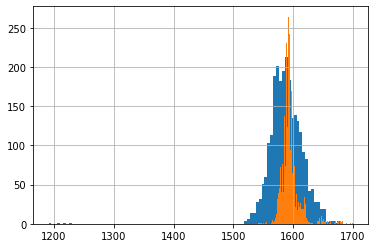

In [69]:
# Посмотрим на график температур чтобы увидеть есть ли выбросы
data_target["temp_first"].hist(bins = 100)
data_target["temp_last"].hist(bins = 100)

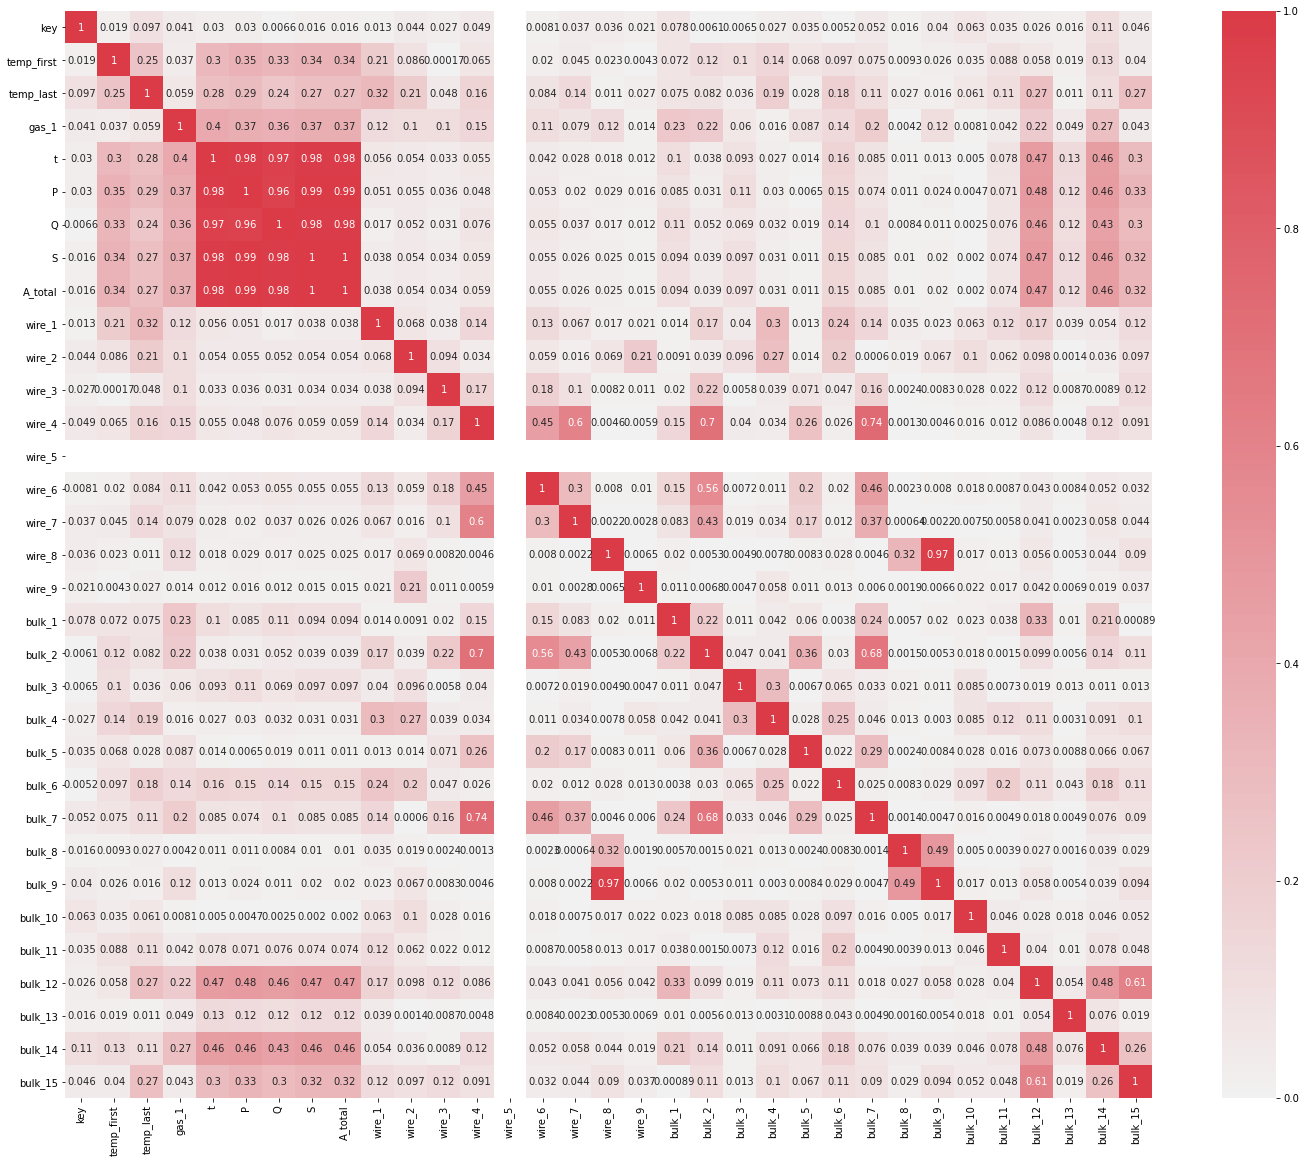

In [70]:
corr = abs(df.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          # The data to plot
#     mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=1,       # The maximum value of the legend. All higher vals will be same color
    vmin=0,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=0, # Width of lines that divide cells
#     cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
    xticklabels=True, yticklabels=True
)

In [71]:
# Интересно полностью пустой этап, его можно удалить
print(df['wire_5'].sum())

0.0


**Вывод** по матрцие кореляций видим те параметры, которые содержаться в формуле полсчета `A_total` максимально корелируются между собой, оставим только его, все остальные дропнем. Также дропнем номера партий, пустой wire.

In [72]:
df = df.drop(["S", "Q", "P", "wire_5", "key", "t", 'time_first','time_last'], axis = 1)

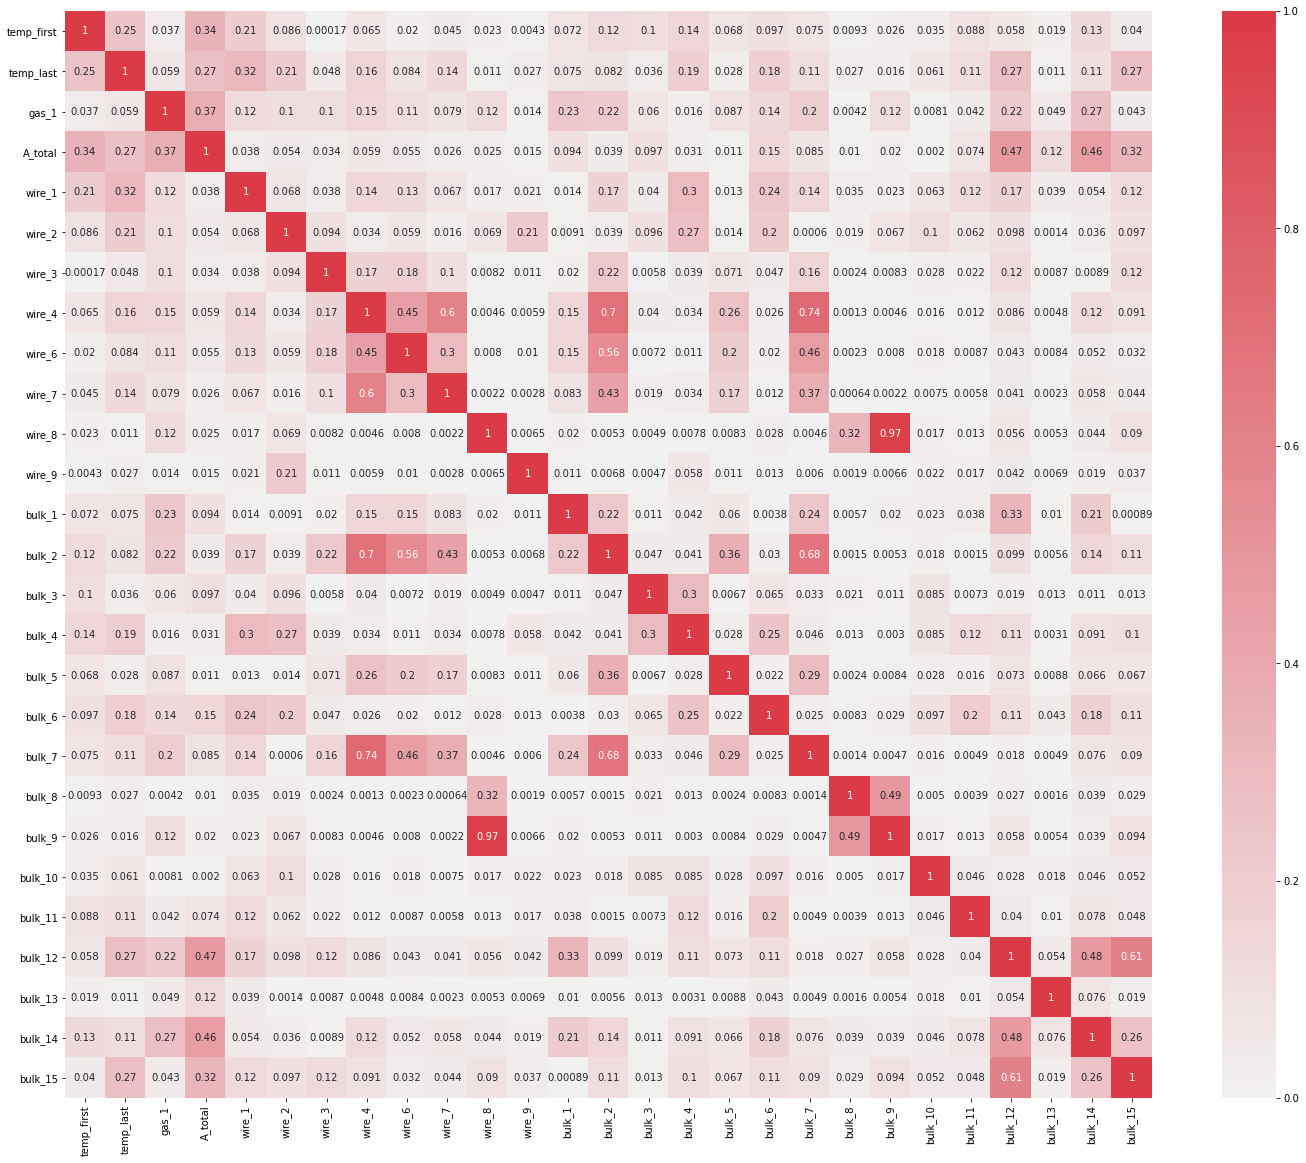

In [73]:
corr = abs(df.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          # The data to plot
#     mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=1,       # The maximum value of the legend. All higher vals will be same color
    vmin=0,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=0, # Width of lines that divide cells
#     cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
    xticklabels=True, yticklabels=True
)

Осталась непонятная кореляция параметров между bulk_9 и wire_8, нужто это учесть

In [74]:
df = df.drop(['wire_8'], axis = 1)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_first  2331 non-null   float64
 1   temp_last   2331 non-null   float64
 2   gas_1       2331 non-null   float64
 3   A_total     2331 non-null   float64
 4   wire_1      2331 non-null   float64
 5   wire_2      2331 non-null   float64
 6   wire_3      2331 non-null   float64
 7   wire_4      2331 non-null   float64
 8   wire_6      2331 non-null   float64
 9   wire_7      2331 non-null   float64
 10  wire_9      2331 non-null   float64
 11  bulk_1      2331 non-null   float64
 12  bulk_2      2331 non-null   float64
 13  bulk_3      2331 non-null   float64
 14  bulk_4      2331 non-null   float64
 15  bulk_5      2331 non-null   float64
 16  bulk_6      2331 non-null   float64
 17  bulk_7      2331 non-null   float64
 18  bulk_8      2331 non-null   float64
 19  bulk_9      2331 non-null  

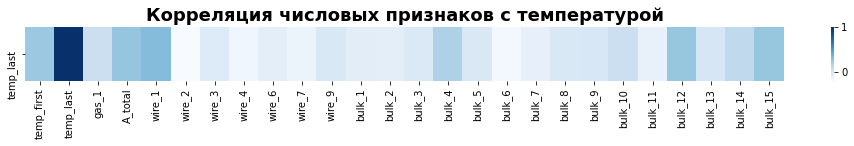

In [76]:
num=df.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['temp_last'], ascending=False).head(1), cmap='Blues')
plt.title("Корреляция числовых признаков с температурой", weight='bold', fontsize=18)
plt.show()

In [77]:
random_state = 302022
train, test = train_test_split(df, test_size = 0.25, random_state = random_state)
cv_counts = 7

Сделаем масштабирование признаков

In [78]:
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ("temp_last")]
scaler = MinMaxScaler()
scaler.fit(train[numeric])
train[numeric] = scaler.transform(train[numeric])
test[numeric] = scaler.transform(test[numeric])

In [79]:
x_train = train.drop(['temp_last'], axis = 1)
y_train = train['temp_last']
x_test = test.drop(['temp_last'], axis = 1)
y_test = test['temp_last']

y = df['temp'] # Целевой признак
x = df.drop(['temp'], axis = 1) # Остальный признаки

random_state = 302022
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.25, 
                                                    random_state = random_state)
cv_counts = 7

## LinearRegression

In [80]:
%%time

regressor = LinearRegression()
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(regressor, 
                             x_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of LinearRegression =', cv_MAE_LR)

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression = 6.585786325794571
Wall time: 36 ms


## RandomForestRegressor

In [81]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(50, 701, 50)], 
                'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(x_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'mse', 'n_estimators': 700, 'random_state': 302022}

Grid scores on development set:

6.271142 for {'criterion': 'mse', 'n_estimators': 50, 'random_state': 302022}
6.229280 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 302022}
6.231207 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 302022}
6.228300 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 302022}
6.219160 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 302022}
6.224323 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 302022}
6.224366 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 302022}
6.228105 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 302022}
6.226412 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 302022}
6.223508 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 302022}
6.220641 for 

## CatBoostRegressor

In [82]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             x_train, 
                             y_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)
print()
print("Best parameters set found on development set:")
print()
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(x_train, 
                                        y_train).get_all_params()
best_params_CBR

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 6.137663344790252

Best parameters set found on development set:

Wall time: 13.3 s


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 302022,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04472000151872635,
 'score_function': 'Cosine',
 'task_

## LGMBRegressor

In [83]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[x for x in range(4,31)], 
                'learning_rate':[x/100 for x in range(1, 11)],
                'random_state':[random_state]}]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=cv_counts)
clf.fit(x_train, y_train)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_LGBMR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'learning_rate': 0.04, 'num_leaves': 21, 'random_state': 302022}

Grid scores on development set:

7.252395 for {'learning_rate': 0.01, 'num_leaves': 4, 'random_state': 302022}
7.161693 for {'learning_rate': 0.01, 'num_leaves': 5, 'random_state': 302022}
7.089668 for {'learning_rate': 0.01, 'num_leaves': 6, 'random_state': 302022}
7.036784 for {'learning_rate': 0.01, 'num_leaves': 7, 'random_state': 302022}
6.989823 for {'learning_rate': 0.01, 'num_leaves': 8, 'random_state': 302022}
6.949372 for {'learning_rate': 0.01, 'num_leaves': 9, 'random_state': 302022}
6.920794 for {'learning_rate': 0.01, 'num_leaves': 10, 'random_state': 302022}
6.893738 for {'learning_rate': 0.01, 'num_leaves': 11, 'random_state': 302022}
6.870669 for {'learning_rate': 0.01, 'num_leaves': 12, 'random_state': 302022}
6.853158 for {'learning_rate': 0.01, 'num_leaves': 13, 'random_state': 302022}
6.815884 for {'lea

# Тестирование моделей

## LinearRegression

In [84]:
%%time

model = LinearRegression()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
test_MAE_LR = mean_absolute_error(y_predict, y_test)
print('MAE on test for LinearRegression =', test_MAE_LR)

MAE on test for LinearRegression = 7.6186450180425105
Wall time: 7.94 ms


## RandomForestRegressor

In [85]:
%%time

model = RandomForestRegressor()
model.set_params(**best_params_RFR)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
test_MAE_RFR = mean_absolute_error(y_predict, y_test)
print('MAE on test of RandomForestRegressor =', test_MAE_RFR)

MAE on test of RandomForestRegressor = 6.017797108551831
Wall time: 5.28 s


## CatBoostRegressor

In [86]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
test_MAE_CBR = mean_absolute_error(y_predict, y_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 6.085851819647603
Wall time: 1.76 s


## LGMBRegressor

In [87]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
test_MAE_LGBMR = mean_absolute_error(y_predict, y_test)
print('MAE on test of LGBMRegressor =', test_MAE_LGBMR)

MAE on test of LGBMRegressor = 6.02621362329364
Wall time: 89.3 ms


# Итог

In [88]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_CBR,
                     cv_MAE_LGBMR],
        'MAE на тесте':[test_MAE_LR,
                        test_MAE_RFR,
                        test_MAE_CBR,
                        test_MAE_LGBMR]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['MAE на тесте'] <= 6.8
scores_data

,MAE на CV,MAE на тесте,Выполнение задачи
LinearRegression,6.585786,7.618645,False
RandomForestRegressor,6.214570,6.017797,True
CatBoostRegressor,6.137663,6.085852,True
LGBMRegressor,6.077035,6.026214,True


## График фажности факторов

In [89]:
importances = model.feature_importances_
feature_list = list(x_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,A_total,414
1,temp_first,404
2,gas_1,211
3,wire_1,174
4,bulk_14,143
5,wire_2,138
6,bulk_12,128
7,bulk_6,124
8,bulk_1,83
9,bulk_15,77


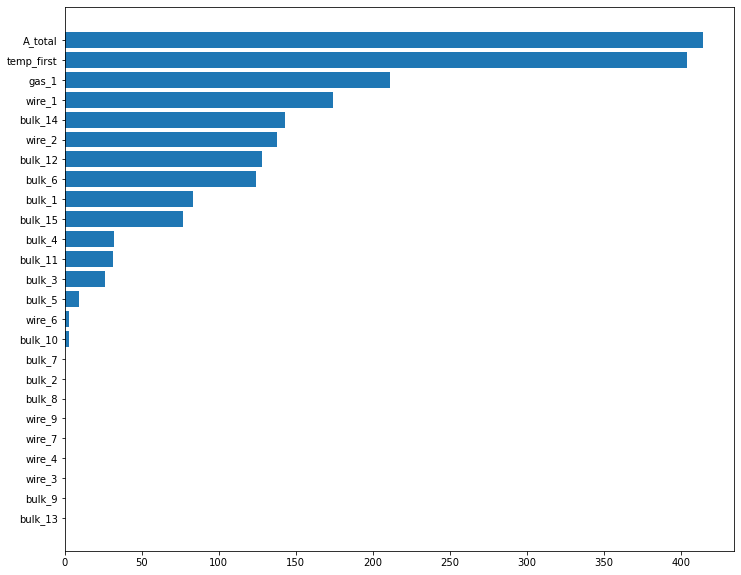

In [90]:
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(x_train.columns)[indices])

**Вывод** 

Видим что ценности для модели особне не представляют или не представляют следующие факторы: `bulk_7, bulk_2, bulk_8, wire_9, wire_7, wire_4, wire_3, bulk_9, bulk_13`, но в целом мы достигли нужного качества

# Итоговый вывод и отчет

**По итогу было выполнено:**
    
1) Выстроен план работы

2) Изучены и подготовлены данные

3) На основе изученных данных стало понятно, что это задача регрессии

4) Далее мы предобработали данные, привели их в порядок, поработали с пропусками

5) Согласно физическам формуле начали считать полную мощность и работу

6) По итогу преобработанных данных начали формировать финальный датасет, проверив мультиколлинеарность

7) По колрреляционной матрице выявили факторы для удаления из таблицы в угоду недо/пере обучения

8) Построили график корреляции оставшихся признаков с целевым признаком

9) Создали обучающую и тестовую выборку для моделей с использованием масштабирования

10) Обучили такие регрессионные модели как: Linear, RandomForest, CatBoost, LGBM (с поиском лучших гиперпараметров GridSerachCV)

11) Запустили тестирование моделей на тест данных

12) Вывели итоговые значения качества моделей

**Вывод**

В ходе работы были обучены такие регрессионные модели как: Linear, RandomForest, CatBoost, LGBM.

Лучшей моделью оказалась RandomForest = 6.017797, однако и другие модели кроме LinearRegressor выполнели требования на качество прогноза.

Основной проблемой можно назвать качество и бизнес адекватность данных, очень много пропусков, не соответсвие принципу замер - добавки/продувки - замер.